# Client-side A/B testing of two prompts

In this notebook, you will learn how to run a simple A/B test on two different prompts. You will build a human-like chatbot buddy, using OpenAI and Literal AI. 

Two prompts will be formulated, A and B, and new conversations will automatically route to prompt versions A or B. 
These Threads will be sent to Literal AI and tagged, to keep track of the group. Then, LLM answers of both groups will be tested against "human-likeness", using AI (OpenAI). Finally, a boxplot shows the difference between the two groups, having different formulated prompt. 

In this notebook, the A/B test happens client-side (in this notebook). 
This is a simple example of an A/B test, and serves as inspiration for your own project, where you can use other means to evaluate version A against version B (e.g. button clicks, user satisfaction, etc).

In [1]:
from literalai import LiteralClient
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()

literalai_client = LiteralClient()
openai_client = OpenAI()

literalai_client.instrument_openai()

## 1. Define prompts

Let's define two different prompts, which will be compared in the A/B test. 
- Prompt A is a standard, short prompt not specific to this use case.  
- Prompt B is a prompt specified to the use case of building a human-like chatbot that can talk about emotions, use figure of speech and should sound more like a human.

We'll save both prompts to Literal AI. 

In [2]:
PROMPT_A = "Prompt A - standard"
template_messages_A = [
    {
        "role": "system",
        "content": "You are a helpful assistant that always answers questions. Keep it short."
    },
    {
        "role": "user",
        "content": "{{question}}"
    }
]
prompt_A = literalai_client.api.get_or_create_prompt(name=PROMPT_A, template_messages=template_messages_A)

In [3]:
PROMPT_B = "Prompt B - human-like"
template_messages_B = [
    {
        "role": "system",
        "content": "You are a helpful assistant that always answers questions. Keep it short. Answer like you are a real human. For example, you can use emotions, metaphors and proverbs. Try to always be positive, and help the user with their questions, doubts and problems. Don't be pessimistic."
    },
    {
        "role": "user",
        "content": "{{question}}"
    }
]
prompt_B = literalai_client.api.get_or_create_prompt(name=PROMPT_B, template_messages=template_messages_B)

## 2. Build the chatbot, randomly assign a prompt version

In the first function, `run_agent()`, OpenAI is used to generate an answer to a user question. This step is added as a `Run` step to Literal AI. 

In the second function, `app()`, a prompt is randomly assigned to a new conversation, and user and chatbot messages are sent to Literal AI for logging.  
Tags are added to the Thread for later reference of the testing group.

In [4]:
@literalai_client.step(type="run", name="Agent Run")
def run_agent(user_query: str, group: str):
        
    # assign prompt A or B
    if group == "A":
        messages = prompt_A.format_messages(question=user_query)
    else:
        messages = prompt_B.format_messages(question=user_query)

    # run gpt
    completion = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )

    # extract answer
    answer = completion.choices[0].message.content

    return answer

In [5]:
import random
import time

def app(questions):
    for idx, question in enumerate(questions):
        with literalai_client.thread(name=f"Question {idx+1}") as thread:
            # assign prompt A or B
            if random.random() < 0.5:
                group = "A"
            else:
                group = "B"
                
            # add tag to thread for later reference
            thread.tags=[group]

            literalai_client.message(content=question, type="user_message", name="User")
            answer = run_agent(question, group)
            literalai_client.message(content=answer, type="assistant_message", name="My Assistant")
    
    time.sleep(5) # to make sure all threads are uploaded to Literal AI before going to the next step

## 3. Run app with sample data
Create some sample questions as data.

In [6]:
questions = [
    "What should I do when I feel sad?",
    "What do you think about falling in love?",
    "What do you think about getting divorced?",
    "What should I do when I feel happy?",
    "What should I do if I feel tired?",
    "What do you think of the movie Star Wars?",
    "What do you think of the book Harry Potter?",
    "What do you think about AI?",
    "How do you feel about traveling?",
    "How do I motivate myself to do sports?"
]

In [7]:
app(questions)

After running this, Threads are visible from the Literal AI platform.

![Threads in Literal AI](img/threads.png)

## 4. Create Datasets
Create two datasets of the Threads filtered by population Tag.

In [11]:
def get_threads(tag: str):
    threads = literalai_client.api.get_threads(filters=[{
        "field": "tags",
        "operator": "in",
        "value": [tag]
    }]).data

    return threads

In [19]:
def create_dataset(threads):
    dataset = []

    for thread in threads:
        for step in thread.steps:
            if step.name == "Agent Run":
                data_item = {
                    "input": step.input,
                    "output": step.output["content"]
                }
                dataset.append(data_item)
    return dataset

In [20]:
threads_A = get_threads(tag="A")
dataset_A = create_dataset(threads=threads_A)

threads_B = get_threads(tag="B")
dataset_B = create_dataset(threads=threads_B)

# Run A/B Experiment
This happens client-side. A GPT-4 prompt is made, as evaluation agent. Then, all items are evaluated, per group.

In [21]:
def analyze(text):
    messages = [
        {"role": "system", "content": """You are trained to analyze and detect the sentiment of given text."""},
        {"role": "user", "content": f"""Analyze the following recommendation and determine if the output is human-like. Check if there are emotions used, and metaphors and figure of speech. 
                                        Assign a score: Based on your evaluation assign a score to the agent's performans using the following scale:
                                        - 1 (Poor): The agent is very machine like, doesn't use emotions, methaphors and figure of speech.
                                        - 2 (Fair): The agent is some human-likeness, some emotions, methaphors and figure of speech are used
                                        - 3 (Good): The agent is is human-like, uses enough emotions, methaphors and figure of speech.
                                        - 4 (Very Good): The agent very human-like, uses multiple emotions, methaphors and figure of speech.
                                        - 5 (Excellent): You almost cannot distinguish between the machine and the human, a lot emotions, methaphors and figure of speech are used.

                                        After evaluating the conversation based on the criteria above, provide your score as an integer between 1 and 5. Only answer with a single character in the following value {1, 2, 3, 4, 5}.
                                        Don't provide explanations, only the single integer value.

                                        Text to evaluate: 
                                        {text}

                                        Scoring Output:
                                        """}
    ]
   
    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages, 
        max_tokens=1, 
        n=1, 
        stop=None, 
        temperature=0
    )

    response_text = response.choices[0].message.content

    return response_text

In [22]:
def create_experiment(dataset):     
    scores = []   
    for item in dataset:
        score = analyze(item["output"])

        scores.append(int(score))

    return scores
        


In [23]:
scores_A = create_experiment(dataset_A)
scores_B = create_experiment(dataset_B)

Let's see the final scores per group, on a scale of 0 to 1.

In [24]:
print("Group A:", scores_A)
print("Group B:", scores_B)

Group A: [1, 3, 2, 4]
Group B: [5, 5, 4, 5, 5, 5]


## 5. Visualize Experiment Results

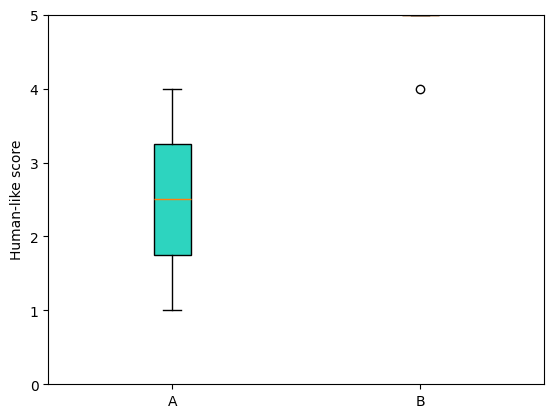

In [25]:
import matplotlib.pyplot as plt

labels = ['A', 'B']
colors = ['#2DD4BF', '#F43F5E']

fig, ax = plt.subplots()
ax.set_ylabel('Human-like score')
ax.set_ylim([0, 5])

bplot = ax.boxplot([scores_A, scores_B],
                   patch_artist=True,  # fill with color
                   tick_labels=labels)  # will be used to label x-ticks

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

It's clear that group B is scored more "human-like"! 